In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random

from transmitter import transmitter
from receiver import receiver

In [2]:
def success(a, b):
    """find the percentage difference between two lists"""
    successes = 0

    for index, i in enumerate(a):
        if i == b[index]:
            successes += 1 / len(a)

    return successes

### Transmitter

LDPC Padding Length: 392
OFDM Padding Length: 3296


/Users/maxiyengar/Documents/GF3/GF3/ldpc_jossy/transmitter.py:92: ComplexWarning: Casting complex values to real discards the imaginary part
  to_transmit[index]  = np.concatenate((cyclic_prefix, x), axis = None)


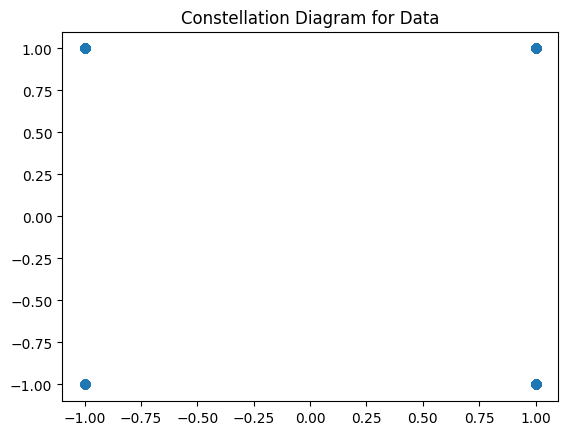

[0 1 0 0 0 0 0 1 0 1 1 0 0 0 1 1 0 1 1 0 0 0 1 1 0 1 1 0 1 1 1 1 0 1 1 1 0
 0 1 0 0 1 1 0 0 1 0 0 0 1 1 0 1 0 0 1 0 1 1 0 1 1 1 0 0 1 1 0 0 1 1 1 0 0
 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 1 0 1 1 1 1 0 0 1 0]


In [3]:
t = transmitter()

# to_transmit = t.transmit("max_test_in.txt")
# # N.B. I think my gray coding method is v. slow(?)

binary_data = t.process_file("max_test_in.txt")
ldpc_encoded = t.ldpc_encode(binary_data)
to_transmit = t.ofdm(ldpc_encoded)

plt.scatter(t.constellation[0:500].real, t.constellation[0:500].imag)
plt.title("Constellation Diagram for Data")
plt.show()

print(binary_data[0:100])


### Simulated Channel

In [22]:
channel_response = np.loadtxt('../weekend_files/channel.csv', delimiter = ",", dtype = "float")

to_decode = np.convolve(channel_response, to_transmit)

to_decode = to_decode[:-1 * len(channel_response) + 1]

# NOISE

for index, i in enumerate(to_decode):
    to_decode[index] = i + random.gauss(0.0, 0.01)

### Decoder

In [23]:
r = receiver()

sigmas = [0.05, 0.1, 0.12, 0.135, 0.15, 0.165, 0.18, 0.2, 0.25]
error_rates = []

ldpc_coded, llrs = r.ofdm(to_decode, 0) # Again I think the gray coding is quite slow
decoded = r.ldpc_decode(ldpc_coded, llrs, mode="hard")
text = r.decode_text(decoded)

print("Error rate (No LDPC)", 1 - success(ldpc_coded, ldpc_encoded))
print("Error rate (w/ LDPC) - hard:", 1 - success(decoded, binary_data))

for sigma2 in sigmas:
    ldpc_coded, llrs = r.ofdm(to_decode, sigma2) # Again I think the gray coding is quite slow

    decoded = r.ldpc_decode(ldpc_coded, llrs)
    text = r.decode_text(decoded)

    print("Error rate (w/ LDPC) - soft", 1 - success(decoded, binary_data))
    error_rates.append(1 - success(decoded, binary_data))

# noise_estimator = []

# for index, i in enumerate(r.constellations[0]):

#     if np.real(t.constellation[index]) >= 0 and np.imag(t.constellation[index]) >= 0:
#         color='red'
#         noise_estimator.append(t.constellation[index] - i)
#     elif np.real(t.constellation[index]) <= 0 and np.imag(t.constellation[index]) >= 0:
#         color='blue'
#     elif np.real(t.constellation[index]) <= 0 and np.imag(t.constellation[index]) <= 0:
#         color='green'
#     elif np.real(t.constellation[index]) >= 0 and np.imag(t.constellation[index]) <= 0:
#         color='yellow'

#     plt.scatter(i.real, i.imag, color=color, alpha=0.5)

# plt.title("Received constellation diagram under simulated channel")
# plt.show()

# sigma2 = 0
# for i in noise_estimator:
#     sigma2 += (i.real**2 + i.imag**2) / len(noise_estimator)

# print(sigma2)


Number of OFDM Blocks:  62208
Error rate (No LDPC) 0.08269032921696617
Error rate (w/ LDPC) - hard: 0.06564209429510015
Number of OFDM Blocks:  62208
Error rate (w/ LDPC) - soft 0.003679343578705474
Number of OFDM Blocks:  62208
Error rate (w/ LDPC) - soft 0.002572284448722595
Number of OFDM Blocks:  62208
Error rate (w/ LDPC) - soft 0.0024094816354898185
Number of OFDM Blocks:  62208
Error rate (w/ LDPC) - soft 0.0026374055740157054
Number of OFDM Blocks:  62208
Error rate (w/ LDPC) - soft 0.0028653295125415923
Number of OFDM Blocks:  62208
Error rate (w/ LDPC) - soft 0.0031583745763605897
Number of OFDM Blocks:  62208
Error rate (w/ LDPC) - soft 0.0033537379522399213
Number of OFDM Blocks:  62208
Error rate (w/ LDPC) - soft 0.0037119041413520293
Number of OFDM Blocks:  62208
Error rate (w/ LDPC) - soft 0.009084396978033649


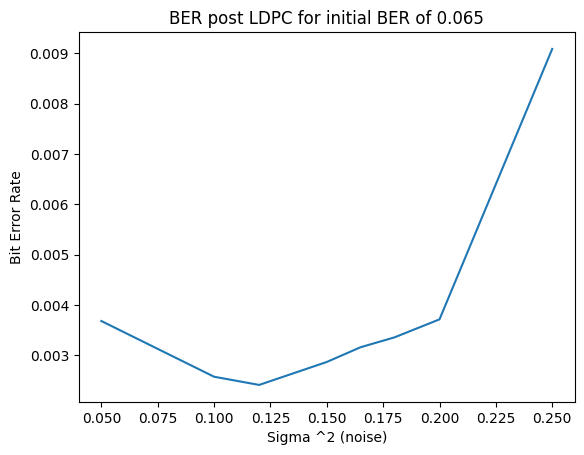

In [24]:
plt.plot(sigmas, np.array(error_rates))
plt.xlabel("Sigma ^2 (noise)")
plt.ylabel("Bit Error Rate")
plt.title("BER post LDPC for initial BER of 0.065")

plt.show()